# Binned Jeans analysis tutorial

In this example, we will use JeansGNN to perform a binned Jeans analysis to recover
the dark matter density profile of an example dwarf galaxy.

This implementation is based on the following paper:
- [1] Chang & Necib (2020) https://arxiv.org/abs/2009.00613

In [1]:
%cd /jet/home/tvnguyen/JeansGNN/experiments
%load_ext autoreload
%autoreload 2

/jet/home/tvnguyen/JeansGNN/experiments


In [2]:
import numpy as np
import jax
import jax.numpy as jnp
import scipy
import matplotlib.pyplot as plt
import corner
import astropy.constants as const
import astropy.units as u

# import flowMC dependencies
from flowMC.sampler.MALA import MALA
from flowMC.sampler.HMC import HMC
from flowMC.sampler.Gaussian_random_walk import GaussianRandomWalk
from flowMC.nfmodel.realNVP import RealNVP
from flowMC.nfmodel.rqSpline import RQSpline
from flowMC.sampler.Sampler import Sampler
from flowMC.utils.PRNG_keys import initialize_rng_keys

# import JeansGNN dependencies
import jeans_gnn as jgnn
import utils

%matplotlib inline

/ocean/projects/ast200012p/tvnguyen/miniconda3/envs/jeans-gnn/lib/python3.8/site-packages/flax/struct.py:136: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/ocean/projects/ast200012p/tvnguyen/miniconda3/envs/jeans-gnn/lib/python3.8/site-packages/flax/struct.py:136: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/ocean/projects/ast200012p/tvnguyen/miniconda3/envs/jeans-gnn/lib/python3.8/site-packages/flax/struct.py:136: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


In [3]:
print(jax.devices())

[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]


As a first step, we load an example dwarf galaxy simulation from the `data` directory.

In [4]:
# Read the example datasets and pick the first galaxy (though any galaxy will work)
dataset_path = 'data/example_data.hdf5'
node_features, graph_features, headers = jgnn.utils.dataset.read_graph_dataset(
    dataset_path, features_list=['pos', 'vel', 'vel_error', 'labels'])

# Pick the first galaxy
pos = node_features['pos'][1]
vel = node_features['vel'][1]
vel_error = node_features['vel_error'][1]
truth_parameters = {
    k: v for k, v in zip(headers['labels_order'], graph_features['labels'][1])}

# Print out the truth parameters and the node features of the first 10 stars
print('True parameters:')
for k, v in truth_parameters.items():
    print(f'{k}: {v}')
print("Node features:")
print("- pos: {}".format(node_features['pos'][0][:10]))
print("- vel: {}".format(node_features['vel'][0][:10]))

True parameters:
dm_gamma: 1.0077498109274279
dm_log_r_dm: -0.633612420092535
dm_log_rho_0: 6.866133214871631
stellar_log_r_star: -1.2141546817176612
df_beta_0: 0.12881816386775002
df_log_r_a: -0.9183926283597472
Node features:
- pos: [[ 0.13504457  0.05950324]
 [-0.03729184 -0.151646  ]
 [-0.11927976 -0.11157647]
 [-0.03330625  0.06756137]
 [-0.00840738  0.03095477]
 [ 0.07772832 -0.04542598]
 [-0.06865919 -0.04856362]
 [ 0.02304553  0.0593613 ]
 [ 0.00202816  0.00174576]
 [ 0.10052064  0.04847484]]
- vel: [ 0.29824803 -0.04545442  0.21565156 -0.46745416 -0.20959343 -0.14228842
  0.66527882  0.53476856  0.24639451 -0.36439535]


In [5]:
# Convert all arrays to jax arrays
pos = jnp.array(pos)
vel = jnp.array(vel)
vel_error = jnp.array(vel_error)
radius_proj = jnp.linalg.norm(pos, axis=-1)

truths = jnp.array([len(pos), 10**truth_parameters['stellar_log_r_star']])

2023-06-01 14:19:42.732876: W external/xla/xla/service/gpu/nvptx_compiler.cc:564] The NVIDIA driver's CUDA version is 12.0 which is older than the ptxas CUDA version (12.1.105). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


## Define stellar density profile and log-likelihood function

In [7]:
def log_plummer2d(r: jnp.ndarray, L: float, r_star: float) -> jnp.ndarray:
    """ Compute the log density of the 2D Plummer profile.
    Here, r is the projected radius instead of the 3D radius. Equation:
    ```
    log10 rho(r) = log10 L - 2 log10 r_star - 2 log10 (1 + r^2 / r_star^2) - log10 pi
    ```
    where:
        L: luminosity
        r_star: scale radius
    
    Parameters
    ----------
    r: jnp.ndarray
        The radius
    L: float
        The log luminosity
    r_star: float
        The scale radius
    
    Returns
    -------
    jnp.ndarray
        The log density    
    """
    x = r / r_star
    return jnp.log10(L) - 2 * jnp.log10(r_star) - 2 * jnp.log10(1 + x**2) - jnp.log10(jnp.pi)

In [6]:
# compute the observed surface density profile
Sigma, Sigma_lo, Sigma_hi, logR_bins_lo, logR_bins_hi = utils.calc_Sigma(radius_proj)
logR_bins_ce = 0.5 * (logR_bins_lo + logR_bins_hi)
sig_lo = Sigma - Sigma_lo
sig_hi = Sigma_hi - Sigma
V1 = sig_lo * sig_hi
V2 = sig_hi - sig_lo

def log_likelihood(theta: jnp.ndarray, data=None):
    """ Log likelihood function defined as:
    ```
        logL = -0.5 * (Sigma - Sigma_hat)^2 / (V1 - V2 * (Sigma - Sigma_hat))
    ```
    where:
    - Sigma is the light profile as inferred from data
    - Sigma_hat is the estimated light profile
    - V1 and V2

    Parameters:
    -----------
    theta: jnp.ndarray
        The parameters of the model
    """
    logL, logr_star = theta
    L = jnp.float_power(10, logL)
    r_star = jnp.float_power(10, logr_star)

    # compute the estimated surface density profile
    Sigma_hat = jnp.float_power(
        10, log_plummer2d(10**logR_bins_ce, L, r_star))

    # compute the log likelihood
    delta_Sigma = Sigma - Sigma_hat
    return -0.5 * jnp.sum(delta_Sigma**2 / (V1 - V2 * delta_Sigma))

### Run FlowMC and sample the posterior

In [ ]:
# flowmc parameters
n_dim = 2  # number of dimensions of the target distribution
n_chains = 20  # number of MCMC chains
n_layer = 8  # number of coupling layers of normalizing flow
n_hidden = 128  # with of hidden layers in MLPs parametrizing coupling layers
n_bins = 8
n_dim = 2
step_size = 0.01
rng_key_set = initialize_rng_keys(n_chains, seed=42)

In [ ]:
# normalizing flow model as Global Sampler
model = RealNVP(n_layer, n_dim, n_hidden)
# model = RQSpline(n_dim, n_layer, n_hidden, n_bins)

# MALA as Local Sampler
MALA_Sampler = MALA(log_likelihood, True, {"step_size": step_size})
local_sampler_caller = lambda x: MALA_Sampler.make_sampler()

# Set up RNG keys and initial positions
initial_position = jax.random.uniform(rng_key_set[0], shape=(n_chains, n_dim)) * 2 - 1

In [24]:
# training parameters
n_loop_training = 20
n_loop_production = 20
n_local_steps = 100
n_global_steps = 10
num_epochs = 10
learning_rate = 0.001
batch_size = 5000
max_samples = 5000

# create Sampler object
nf_sampler = Sampler(
    n_dim,
    rng_key_set,
    None,
    MALA_Sampler,
    model,
    n_loop_training=n_loop_training,
    n_loop_production=n_loop_production,
    n_local_steps=n_local_steps,
    n_global_steps=n_global_steps,
    n_chains=n_chains,
    n_epochs=num_epochs,
    learning_rate=learning_rate,
    batch_size=batch_size,
    use_global=True,
)

jit is requested, precompiling kernels and update...


Start sampling

In [25]:
nf_sampler.sample(initial_position, data=None)

No autotune found, use input sampler_params
Training normalizing flow


Tuning global sampler:   0%|                                                                             | 0/20 [00:00<?, ?it/s]

Tuning global sampler: 100%|████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.68it/s]


Starting Production run


Production run: 100%|███████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 33.39it/s]


### Check the convergence of the chains

In [26]:
out_train = nf_sampler.get_sampler_state(training=True)
print('Logged during tuning:', out_train.keys())

Logged during tuning: dict_keys(['chains', 'log_prob', 'local_accs', 'global_accs', 'loss_vals'])


In [27]:
# chains = np.array(out_train['chains'])
# global_accs = np.array(out_train['global_accs'])
# local_accs = np.array(out_train['local_accs'])
# loss_vals = np.array(out_train['loss_vals'])
# nf_samples = np.array(nf_sampler.sample_flow(1000)[1])


# # Plot 2 chains in the plane of 2 coordinates for first visual check 
# plt.figure(figsize=(10, 10))
# axs = [plt.subplot(2, 2, i + 1) for i in range(4)]
# plt.sca(axs[0])
# plt.title("2d proj of 2 chains")

# plt.plot(chains[0, :, 0], chains[0, :, 1], 'o-', alpha=0.5, ms=2)
# plt.plot(chains[1, :, 0], chains[1, :, 1], 'o-', alpha=0.5, ms=2)
# plt.xlabel("$x_1$")
# plt.ylabel("$x_2$")

# plt.sca(axs[1])
# plt.title("NF loss")
# plt.plot(loss_vals.reshape(-1))
# plt.xlabel("iteration")

# plt.sca(axs[2])
# plt.title("Local Acceptance")
# plt.plot(local_accs.mean(0))
# plt.xlabel("iteration")

# plt.sca(axs[3])
# plt.title("Global Acceptance")
# plt.plot(global_accs.mean(0))
# plt.xlabel("iteration")
# plt.tight_layout()
# plt.show(block=False)

# labels=["$x_1$", "$x_2$", "$x_3$", "$x_4$", "$x_5$"]
# # Plot all chains
# figure = corner.corner(
#     chains.reshape(-1, n_dim), labels=labels
# )
# figure.set_size_inches(7, 7)
# figure.suptitle("Visualize samples")
# plt.show(block=False)

# # Plot Nf samples
# figure = corner.corner(nf_samples, labels=labels)
# figure.set_size_inches(7, 7)
# figure.suptitle("Visualize NF samples")
# plt.show()

### Production sampling

In [28]:
out_prod = nf_sampler.get_sampler_state()
print('Logged in production:', out_prod.keys())

Logged in production: dict_keys(['chains', 'log_prob', 'local_accs', 'global_accs'])


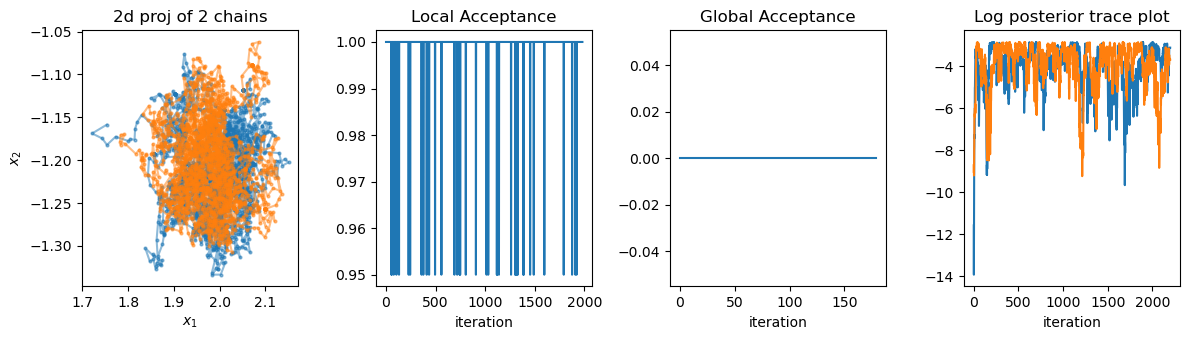

In [29]:
chains = np.array(out_prod['chains'])
index = 7 # choosing random chain index to plot results
global_accs = np.array(out_prod['global_accs'])
local_accs = np.array(out_prod['local_accs'])
log_prob_trace = np.array(out_prod['log_prob'][np.array([index,index+10]),:]).T

plt.figure(figsize=(12, 3.5))
axs = [plt.subplot(1, 4, i + 1) for i in range(4)]
plt.sca(axs[0])
plt.title("2d proj of 2 chains")

plt.plot(chains[index, :, 0], chains[index, :, 1], 'o-', alpha=0.5, ms=2)
plt.plot(chains[index+10, :, 0], chains[index+10, :, 1], 'o-', alpha=0.5, ms=2)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

plt.sca(axs[1])
plt.title("Local Acceptance")
plt.plot(local_accs.mean(0))
plt.xlabel("iteration")

plt.sca(axs[2])
plt.title("Global Acceptance")
plt.plot(global_accs.mean(0))
plt.xlabel("iteration")

plt.sca(axs[3])
plt.title("Log posterior trace plot")
plt.plot(log_prob_trace)
plt.xlabel("iteration")

plt.tight_layout()
plt.show(block=False)

labels=["$x_1$", "$x_2$", "$x_3$", "$x_4$", "$x_5$"]

In [ ]:
# Plot all chains
plot_args = dict(
    truth_color='red', truth_alpha=0.5, truth_kwargs={'linewidth': 2},
    label_kwargs={'fontsize': 16}, title_kwargs={'fontsize': 16},
    show_titles=True, labels=[r'$L$', r'$r_\star$'],
    levels=[0.68, 0.95], smooth=1.0, smooth1d=1.0, quantiles=[0.16, 0.5, 0.84],
)

figure = corner.corner(
    chains.reshape(-1, n_dim), truths=np.log10(truths),
    **plot_args
)
plt.show(block=False)

## Jeans analysis

In [8]:
def log_plummer2d(r: jnp.ndarray, L: float, r_star: float) -> jnp.ndarray:
    """ Compute the log density of the 2D Plummer profile.
    Here, r is the projected radius instead of the 3D radius. Equation:
    ```
    log10 rho(r) = log10 L - 2 log10 r_star - 2 log10 (1 + r^2 / r_star^2) - log10 pi
    ```
    where:
        L: luminosity
        r_star: scale radius
    
    Parameters
    ----------
    r: jnp.ndarray
        The radius
    L: float
        The log luminosity
    r_star: float
        The scale radius
    
    Returns
    -------
    jnp.ndarray
        The log density    
    """
    x = r / r_star
    return jnp.log10(L) - 2 * jnp.log10(r_star) - 2 * jnp.log10(1 + x**2) - jnp.log10(jnp.pi)
    
def log_plummer3d(r: jnp.ndarray, L: float, r_star: float) -> jnp.ndarray:
    """ Compute the log density of the 3D Plummer profile.
    Equation:
    ```
    log10 rho(r) = log10 L - 3 log10 r_star - 5/2 log10 (1 + r^2 / r_star^2) - log10 4 pi / 3
    ```
    where:
        L: luminosity
        r_star: scale radius
    """
    x = r / r_star
    return (jnp.log10(L) - 3 * jnp.log10(r_star) - (5/2) * jnp.log10(1 + x**2)
            - jnp.log10(4 * jnp.pi / 3))

def log_gnfw(
    r: jnp.ndarray, rho_0: float, r_dm: float, gamma: float) -> jnp.ndarray:
    """ Compute the log density of the generalized NFW profile.
    Equation:
    ```
    log10 rho(r) = log10 rho_0 - gamma * log10(r / r_dm) - (3 - gamma) * log10(1 + r / r_dm)
    ```
    where:
        rho_0: central density
        r_dm: dark matter halo scale radius
        gamma: power law index
    """
    x = r / r_dm
    return jnp.log10(rho_0) - gamma * jnp.log10(x) - (3 - gamma) * jnp.log10(1 + x)

def cmass_gnfw(r: jnp.ndarray, rho_0: float, r_dm: float, gamma: float) -> jnp.ndarray:
    """ Compute the cumulative mass of the generalized NFW profile.
    """    
    density = jnp.float_power(10, log_gnfw(r, rho_0, r_dm, gamma))
    res = utils.jax_cumtrapz_init(y=density, x=r, initial=0)
    return res

def beta_om(r: jnp.ndarray, beta_0: float, r_a: float) -> jnp.ndarray:
    """ Compute the velocity anisotropy of the Osipkov-Merrit distribution function.
    Equation:
    ```
    beta(r) = beta_0 * (r / r_a)^2 / (1 + r / r_a)^2
    ```
    where:
        beta_0: central velocity anisotropy
        r_a: scale radius
    """
    x = r / r_a
    return beta_0 * x**2 / (1 + x)**2

In [9]:
# global data
r_min_factor = 0.5
r_max_factor = 2.0
dr = 0.1

# global parameters for liklihood
r_min = jnp.min(radius_proj) * r_min_factor
r_max = jnp.max(radius_proj) * r_max_factor
int_radius = jnp.arange(r_min, r_max, dr)
vel_var = vel_error**2

In [10]:
# # prior distribution
# min_logrho_0 = 3
# max_logrho_0 = 10
# min_logr_dm = -2
# max_logr_dm = 3
# min_gamma = -2
# max_gamma = 2

# def log_priors(theta):
#     """ Compute the log prior probability for the given parameters.
#     """
#     # Extract all parameters
#     logrho_0 = theta[0]
#     logr_dm = theta[1]
#     gamma = theta[2]

#     log_p = 0
#     log_p += jax.scipy.stats.uniform.logpdf(
#         logrho_0, loc=min_logrho_0, scale=(max_logrho_0-min_logrho_0))
#     log_p += jax.scipy.stats.uniform.logpdf(
#         logr_dm, loc=min_logr_dm, scale=(max_logr_dm-min_logr_dm))
#     log_p += jax.scipy.stats.uniform.logpdf(
#             gamma, loc=min_gamma, scale=(max_gamma-min_gamma))
#     return log_p

# def log_likelihood(theta):
#     """ The log likelihood given a set of DM parameters.
#     For each star the log likelihood is defined as:
#     .. math::
#     logL = -0.5 * (v - v_mean)^2 / (sigma2_p + v_err^2) - 0.5 * log(2 pi  * (sigma2_p + verr^2))

#     where:
#     - v is the velocity of the star
#     - v_mean is the mean velocity of all stars
#     - v_err is the measurement error
#     - sigma2_p is the velocity dispersion
#     """
#     # Extract all parameters
#     logrho_0 = theta[0]
#     logr_dm = theta[1]
#     gamma = theta[2]
#     logr_star = -1.2141547
#     logL = 1.9637878
#     logr_a = -0.9183926
#     beta_0 = 0.12881816386775002
#     v_mean = 0

#     # First, we calculate the projected velocity dispersion profile
#     # calculate the velocity ani Beta(r) and the anisotropy integral g(r)
#     beta = beta_om(int_radius, beta_0, 10**logr_a)
#     gint = utils.calc_gint(int_radius, beta)

#     # Calculate the light porilf at each particle radius
#     Sigma = jnp.float_power(10, log_plummer2d(radius_proj, 10**logL, 10**logr_star))

#     # calculate the DM density profile at each integration radius
#     nu = jnp.float_power(10, log_plummer3d(int_radius, 10**logL, 10**logr_star))

#     # integrate the 3d Jeans velocity dispersion equation
#     cmass = cmass_gnfw(int_radius, 10**logrho_0, 10**logr_dm, gamma)
#     sigma2_nu = utils.calc_sigma2_nu(int_radius, cmass, nu, gint)

#     # integrate the 2d velocity dispersion equation
#     sigma2p_Sigma = utils.calc_sigma2p_Sigma(radius_proj, int_radius, sigma2_nu, beta)
#     sigma2p = sigma2p_Sigma / Sigma 
#     sigma2p *= const.G.to_value(u.kpc**3 / u.Msun / u.s**2) * utils.kpc_to_km**2

#     # calculate the log likelihood from the velocity dispersion
#     # and the velocity measurement error
#     var = sigma2p + vel_var
#     logL = -0.5 * (vel - v_mean)**2 / var
#     logL = logL - 0.5 * jnp.log(2 * jnp.pi * var)
#     logL = jnp.sum(logL)

#     return logL

# def log_posteriors(theta, data=None):
#     """ Compute the log posterior probability for the given parameters.
#     """
#     return log_priors(theta) + log_likelihood(theta)

In [78]:
# prior distribution
min_logrho_0 = 5
max_logrho_0 = 8
min_logr_dm = -2
max_logr_dm = 2
min_gamma = -1
max_gamma = 2

def log_priors(theta):
    """ Compute the log prior probability for the given parameters.
    """
    # Extract all parameters
    logrho_0 = theta[0]
    logr_dm = theta[1]
    gamma = theta[2]

    log_p = 0
    log_p += jax.scipy.stats.uniform.logpdf(logrho_0, loc=0, scale=1)
    log_p += jax.scipy.stats.uniform.logpdf(logr_dm, loc=0, scale=1)
    log_p += jax.scipy.stats.uniform.logpdf(gamma, loc=0, scale=1)
    return log_p

def log_likelihood(theta, data=None):
    """ The log likelihood given a set of DM parameters.
    For each star the log likelihood is defined as:
    .. math::
    logL = -0.5 * (v - v_mean)^2 / (sigma2_p + v_err^2) - 0.5 * log(2 pi  * (sigma2_p + verr^2))

    where:
    - v is the velocity of the star
    - v_mean is the mean velocity of all stars
    - v_err is the measurement error
    - sigma2_p is the velocity dispersion
    """
    # Extract all parameters and apply scaling
    logrho_0 = theta[0] * (max_logrho_0 - min_logrho_0) + min_logrho_0
    logr_dm = theta[1] * (max_logr_dm - min_logr_dm) + min_logr_dm
    gamma = theta[2] * (max_gamma - min_gamma) + min_gamma
    logr_star = -1.2141547
    logL = 1.9637878
    logr_a = -0.9183926
    beta_0 = 0.12881816386775002
    v_mean = 0

    # First, we calculate the projected velocity dispersion profile
    # calculate the velocity ani Beta(r) and the anisotropy integral g(r)
    beta = beta_om(int_radius, beta_0, 10**logr_a)
    gint = utils.calc_gint(int_radius, beta)

    # Calculate the light porilf at each particle radius
    Sigma = jnp.float_power(10, log_plummer2d(radius_proj, 10**logL, 10**logr_star))

    # calculate the DM density profile at each integration radius
    nu = jnp.float_power(10, log_plummer3d(int_radius, 10**logL, 10**logr_star))

    # integrate the 3d Jeans velocity dispersion equation
    cmass = cmass_gnfw(int_radius, 10**logrho_0, 10**logr_dm, gamma)
    sigma2_nu = utils.calc_sigma2_nu(int_radius, cmass, nu, gint)

    # integrate the 2d velocity dispersion equation
    sigma2p_Sigma = utils.calc_sigma2p_Sigma(radius_proj, int_radius, sigma2_nu, beta)
    sigma2p = sigma2p_Sigma / Sigma 
    sigma2p *= const.G.to_value(u.kpc**3 / u.Msun / u.s**2) * utils.kpc_to_km**2

    # calculate the log likelihood from the velocity dispersion
    # and the velocity measurement error
    var = sigma2p + vel_var
    logL = -0.5 * (vel - v_mean)**2 / var
    logL = logL - 0.5 * jnp.log(2 * jnp.pi * var)
    logL = jnp.sum(logL)

    return logL

def log_posteriors(theta, data=None):
    """ Compute the log posterior probability for the given parameters.
    """
    return log_priors(theta) + log_likelihood(theta)

### Run flowMC parameters

In [79]:
# # flowmc parameters
n_dim = 3  # number of dimensions of the target distribution
n_layer = 10  # number of coupling layers of normalizing flow
n_hidden = 128  # with of hidden layers in MLPs parametrizing coupling layers
n_chains = 100  # number of MCMC chains
step_size = 0.005

# training parameters
n_loop_training = 20
n_loop_production = 200
n_local_steps = 1000
n_local_steps = 100
n_global_steps = 100
num_epochs = 100
learning_rate = 1e-4
batch_size = 5000
max_samples = 5000

rng_key_set = initialize_rng_keys(n_chains, seed=40213)
initial_position = jax.random.uniform(
    rng_key_set[0], shape=(n_chains, n_dim),
    minval=jnp.array([0, 0, 0]), 
    maxval=jnp.array([1, 1, 1])
)

In [80]:
# # normalizing flow model as Global Sampler
model = RealNVP(n_layer, n_dim, n_hidden)
# # model = RQSpline(n_dim, n_layer, n_hidden, n_bins)

# # MALA as Local Sampler
# MALA_Sampler = MALA(log_posteriors, True, {"step_size": step_size}, use_autotune=False)
# HMC_Sampler = HMC(log_posteriors, True, {})
GaussianRandomWalk_Sampler = GaussianRandomWalk(
    log_likelihood, True, {"step_size": step_size})

# create Sampler object
nf_sampler = Sampler(
    n_dim,
    rng_key_set,
    None,
    GaussianRandomWalk_Sampler,
    model,
    n_loop_training=n_loop_training,
    n_loop_production=n_loop_production,
    n_local_steps=n_local_steps,
    n_global_steps=n_global_steps,
    n_chains=n_chains,
    n_epochs=num_epochs,
    learning_rate=learning_rate,
    batch_size=batch_size,
    use_global=True,
    # use_global=False,
)

jit is requested, precompiling kernels and update...


In [81]:
nf_sampler.sample(initial_position, data=None)

No autotune found, use input sampler_params
Training normalizing flow


Tuning global sampler: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:59<00:00,  2.98s/it]


Starting Production run


Production run: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 24.76it/s]


Logged during tuning: dict_keys(['chains', 'log_prob', 'local_accs', 'global_accs', 'loss_vals'])


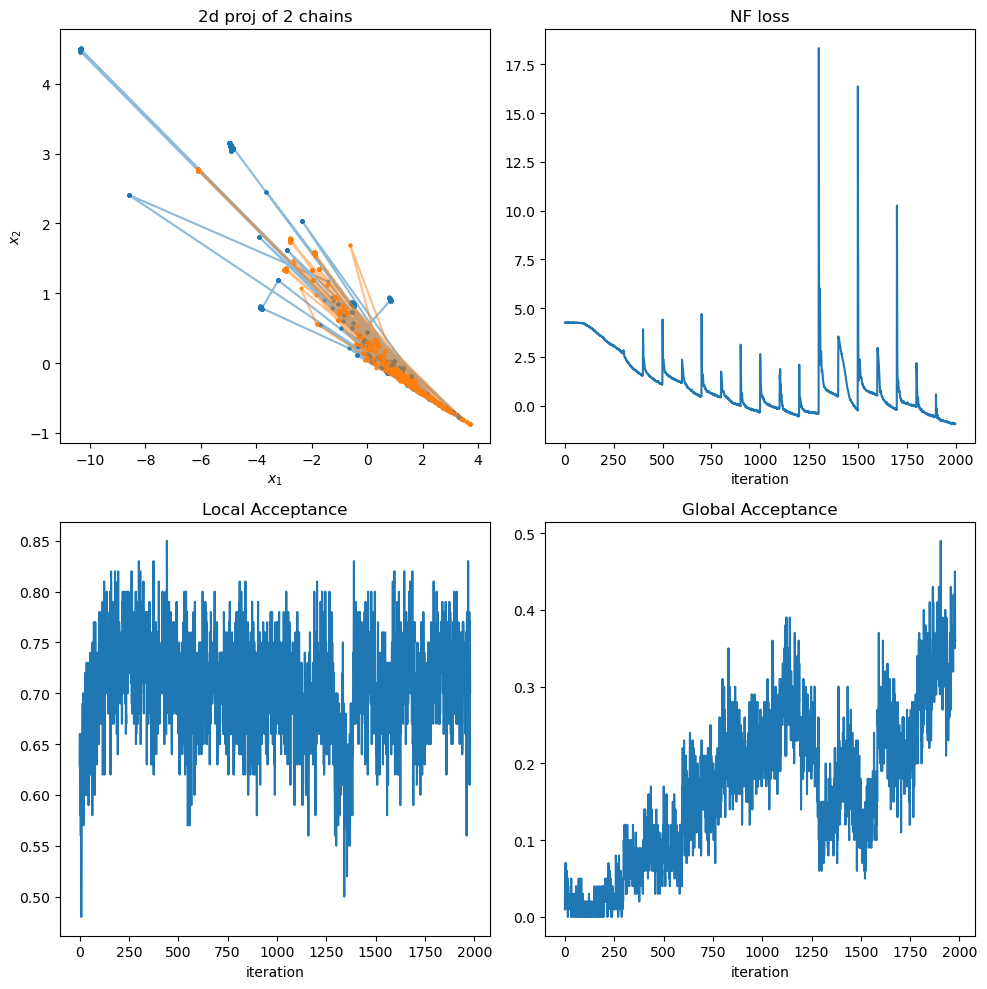

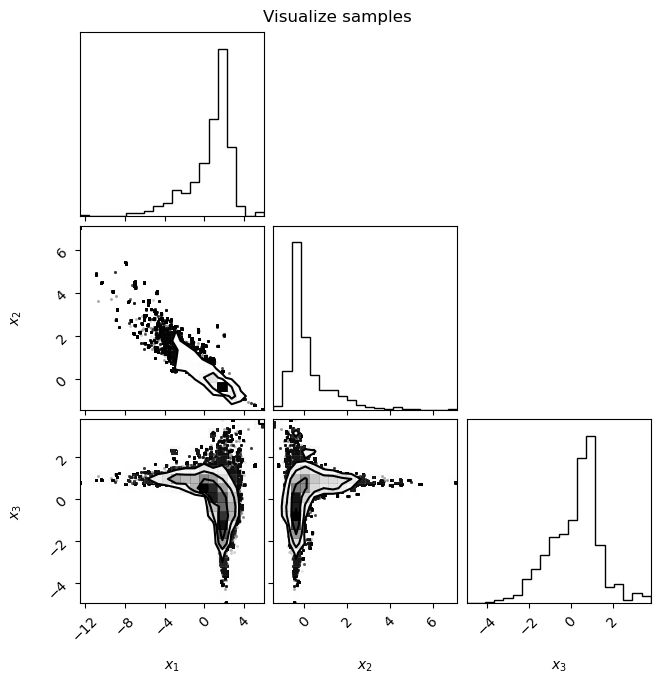

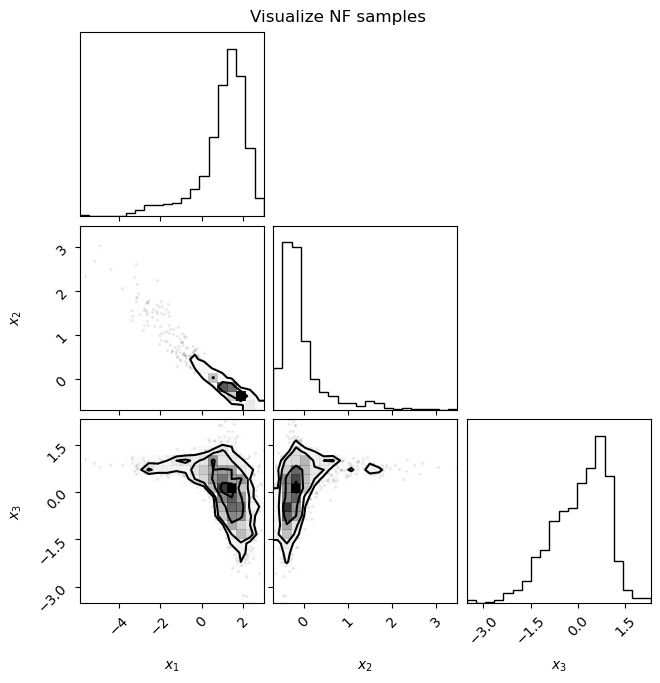

In [82]:
out_train = nf_sampler.get_sampler_state(training=True)
print('Logged during tuning:', out_train.keys())


chains = np.array(out_train['chains'])
global_accs = np.array(out_train['global_accs'])
local_accs = np.array(out_train['local_accs'])
loss_vals = np.array(out_train['loss_vals'])
nf_samples = np.array(nf_sampler.sample_flow(1000)[1])


# Plot 2 chains in the plane of 2 coordinates for first visual check 
plt.figure(figsize=(10, 10))
axs = [plt.subplot(2, 2, i + 1) for i in range(4)]
plt.sca(axs[0])
plt.title("2d proj of 2 chains")

plt.plot(chains[0, :, 0], chains[0, :, 1], 'o-', alpha=0.5, ms=2)
plt.plot(chains[1, :, 0], chains[1, :, 1], 'o-', alpha=0.5, ms=2)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

plt.sca(axs[1])
plt.title("NF loss")
plt.plot(loss_vals.reshape(-1))
plt.xlabel("iteration")

plt.sca(axs[2])
plt.title("Local Acceptance")
plt.plot(local_accs.mean(0))
plt.xlabel("iteration")

plt.sca(axs[3])
plt.title("Global Acceptance")
plt.plot(global_accs.mean(0))
plt.xlabel("iteration")
plt.tight_layout()
plt.show(block=False)

labels=["$x_1$", "$x_2$", "$x_3$", "$x_4$", "$x_5$"]
# Plot all chains
figure = corner.corner(
    chains.reshape(-1, n_dim), labels=labels
)
figure.set_size_inches(7, 7)
figure.suptitle("Visualize samples")
plt.show(block=False)

# Plot Nf samples
figure = corner.corner(nf_samples, labels=labels)
figure.set_size_inches(7, 7)
figure.suptitle("Visualize NF samples")
plt.show()

In [83]:
out_prod = nf_sampler.get_sampler_state()
print('Logged in production:', out_prod.keys())

Logged in production: dict_keys(['chains', 'log_prob', 'local_accs', 'global_accs'])


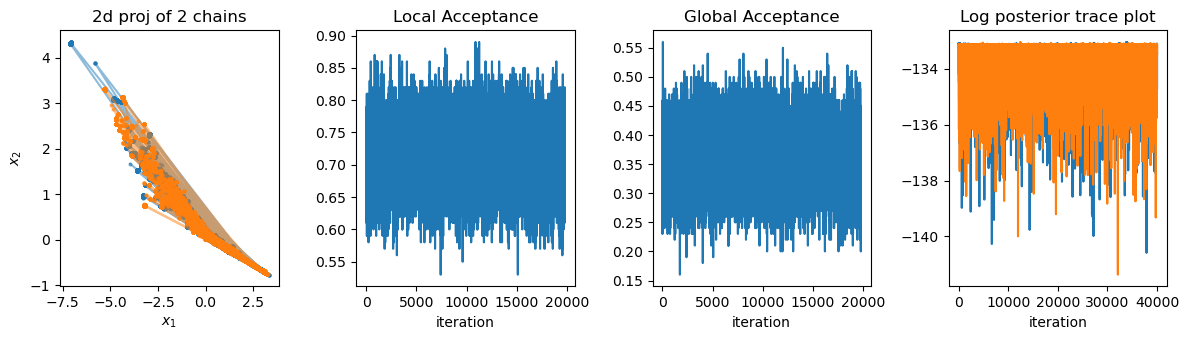

In [84]:
chains = np.array(out_prod['chains'])
index = 0 # choosing random chain index to plot results
global_accs = np.array(out_prod['global_accs'])
local_accs = np.array(out_prod['local_accs'])
log_prob_trace = np.array(out_prod['log_prob'][np.array([index,index+10]),:]).T

plt.figure(figsize=(12, 3.5))
axs = [plt.subplot(1, 4, i + 1) for i in range(4)]
plt.sca(axs[0])
plt.title("2d proj of 2 chains")
plt.plot(chains[index, :, 0], chains[index, :, 1], 'o-', alpha=0.5, ms=2)
plt.plot(chains[index+10, :, 0], chains[index+10, :, 1], 'o-', alpha=0.5, ms=2)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

plt.sca(axs[1])
plt.title("Local Acceptance")
plt.plot(local_accs.mean(0))
plt.xlabel("iteration")

plt.sca(axs[2])
plt.title("Global Acceptance")
plt.plot(global_accs.mean(0))
plt.xlabel("iteration")

plt.sca(axs[3])
plt.title("Log posterior trace plot")
plt.plot(log_prob_trace)
plt.xlabel("iteration")

plt.tight_layout()
plt.show(block=False)

labels=["$x_1$", "$x_2$", "$x_3$", "$x_4$", "$x_5$"]

In [85]:
# get samples and remove burn in
samples = chains[:, 5000:].reshape(-1, n_dim)

# rescale samples to original range
lower = np.array([min_logrho_0, min_logr_dm, min_gamma])
upper = np.array([max_logrho_0, max_logr_dm, max_gamma])
samples = samples * (upper - lower) + lower

truths = np.array([
    truth_parameters['dm_log_rho_0'],
    truth_parameters['dm_log_r_dm'],
    truth_parameters['dm_gamma'],
])

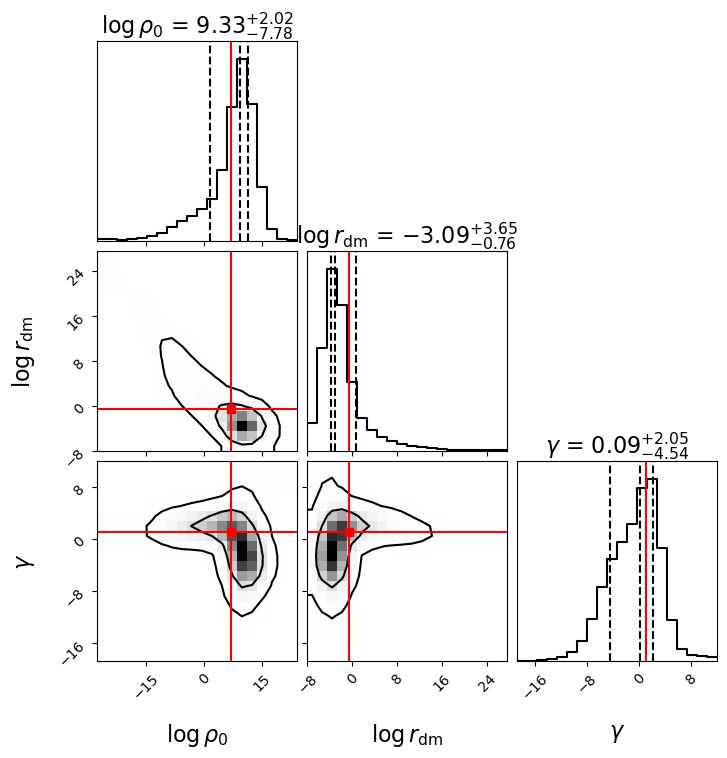

In [86]:
# labels = [r"$\log \rho_0$", r"$\log r_{\rm dm}$", r"$\gamma$", r"$\log r_{\rm star}$", r"$\log L$", r"$\log r_{\rm a}$"]
# labels = [r"$\log \rho_0$", r"$\log r_{\rm dm}$", r"$\gamma$"]
labels = [r"$\log \rho_0$", r"$\log r_{\rm dm}$", r"$\gamma$"]

# Plot all chains
plot_args = dict(
    truth_color='red', truth_alpha=0.5, truth_kwargs={'linewidth': 2},
    label_kwargs={'fontsize': 16}, title_kwargs={'fontsize': 16},
    show_titles=True, levels=[0.68, 0.95], smooth=1.0, smooth1d=1.0, quantiles=[0.16, 0.5, 0.84],
    # range=((min_logrho_0, max_logrho_0), (min_logr_dm, max_logr_dm), (min_gamma, max_gamma)),
    labels=labels, plot_datapoints=False
)

figure = corner.corner(
    samples,  truths=truths, **plot_args
)
plt.show(block=False)